In [1]:
import csv
from xml.etree import ElementTree
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.ticker import StrMethodFormatter
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
from pyclustertend import hopkins, vat, assess_tendency_by_mean_metric_score
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, minmax_scale, RobustScaler,robust_scale
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.pipeline import make_pipeline

In [2]:
# test_cov_file = "C:/Users/aprodea/work/deloitte-tax-i/analysis/last/merged/test_coverage.csv"
test_cov_file = "C:/Users/aprodea/work/metrics-tax-compare/analysis/last/merged/test_coverage.csv"

true_labels = "C:/Users/aprodea/work/metrics-tax-compare/analysis/labelled_data_ext.csv"

def get_labelled_data():
#     file = "C:/Users/aprodea/work/deloitte-tax-i/analysis/last/classification/all_labels.csv"
    file = "C:/Users/aprodea/work/metrics-tax-compare/analysis/last/classification/all_labels.csv"
    data = pd.read_csv(file, sep=';')
    return data

all_labels = get_labelled_data()
all_labels

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall,CLevel_threshold,CLevel_k_means,CLevel_em
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),14.0,3.0,0,1.0,1.0,0,2,2.0,4.0,low,low,high
1,GES_GRT.GES_GRTCoreModule.Initialize(),1.0,1.0,0,0.0,0.0,0,0,1.0,4.0,low,low,low
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),2.0,1.0,0,0.0,0.0,0,1,1.0,4.0,low,low,low
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,2.0,1.0,0,0.0,0.0,5,0,1.0,3707.0,low,low,regular
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),2.0,1.0,0,0.0,0.0,4,0,1.0,2358.0,low,low,regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,8.0,1.0,1,0.0,0.0,1,3,4.0,4.0,low,low,low
800,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.0,3.0,2,0.0,1.0,1,2,1.0,8.0,low,low,low
801,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.0,6.0,2,0.0,1.0,1,2,1.0,8.0,low,low,high
802,GES_GRT.Web.App.Startup.AppNavigationProvider....,2.0,1.0,1,0.0,0.0,0,1,17.0,4.0,regular,low,high


In [3]:
list_columns = all_labels.columns.tolist()
str_cols = ['Method', 'CLevel_threshold', 'CLevel_k_means', 'CLevel_em']
list_columns = [col for col in list_columns if col not in str_cols]
list_columns

['LOC', 'CC', 'NP', 'NV', 'NEST', 'Ca', 'Ce', 'NChg', 'NCall']

In [4]:
all_labels[list_columns].describe()

,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall
count,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000
mean,6.980100,3.231343,1.427861,2.347015,0.871891,0.880597,3.718905,1.796020,291.517413
std,9.758458,4.925974,1.655519,4.278910,0.920098,2.566801,7.098706,2.525227,1808.193170
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,4.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,8.000000,4.000000,2.000000,2.000000,1.000000,1.000000,4.000000,1.000000,4.000000
max,93.000000,71.000000,14.000000,49.000000,10.000000,43.000000,78.000000,39.000000,34659.000000


## QQ plots of data

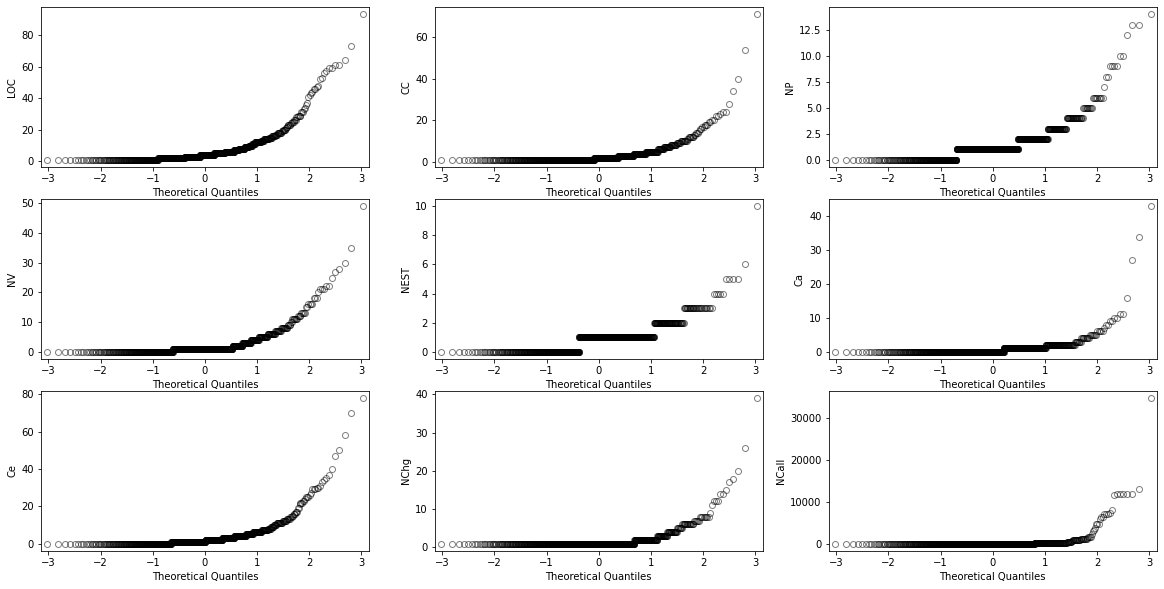

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
ax = axes.flatten()
for i in range(len(list_columns)):
    col_name = list_columns[i]
    sm.qqplot(all_labels[col_name], marker='o', markerfacecolor='none', markeredgecolor='k', alpha=0.5,
              ax = ax[i])
    ax[i].set_ylabel(col_name)

# plt.tight_layout(pad=1.5)
plt.show()

In [6]:
scaled_data = all_labels.copy()

for col_name in list_columns:
    col = scaled_data[col_name]
    min_col, max_col = col.min(), col.max()
#     min_col = 0  # consider min as 0 to perserve the importance of values; eg LOC 25, 50 -> 0.5, 1 
#     print(col_name, min_col, max_col)
    scaled_data[col_name] = (col - min_col) / (max_col - min_col)
    
scaled_data

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall,CLevel_threshold,CLevel_k_means,CLevel_em
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),0.141304,0.028571,0.000000,0.020408,0.1,0.000000,0.025641,0.026316,0.000115,low,low,high
1,GES_GRT.GES_GRTCoreModule.Initialize(),0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000115,low,low,low
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),0.010870,0.000000,0.000000,0.000000,0.0,0.000000,0.012821,0.000000,0.000115,low,low,low
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,0.010870,0.000000,0.000000,0.000000,0.0,0.116279,0.000000,0.000000,0.106956,low,low,regular
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),0.010870,0.000000,0.000000,0.000000,0.0,0.093023,0.000000,0.000000,0.068034,low,low,regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,0.076087,0.000000,0.071429,0.000000,0.0,0.023256,0.038462,0.078947,0.000115,low,low,low
800,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,0.000000,0.028571,0.142857,0.000000,0.1,0.023256,0.025641,0.000000,0.000231,low,low,low
801,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,0.000000,0.071429,0.142857,0.000000,0.1,0.023256,0.025641,0.000000,0.000231,low,low,high
802,GES_GRT.Web.App.Startup.AppNavigationProvider....,0.010870,0.000000,0.071429,0.000000,0.0,0.000000,0.012821,0.421053,0.000115,regular,low,high


## QQ plots of scaled data

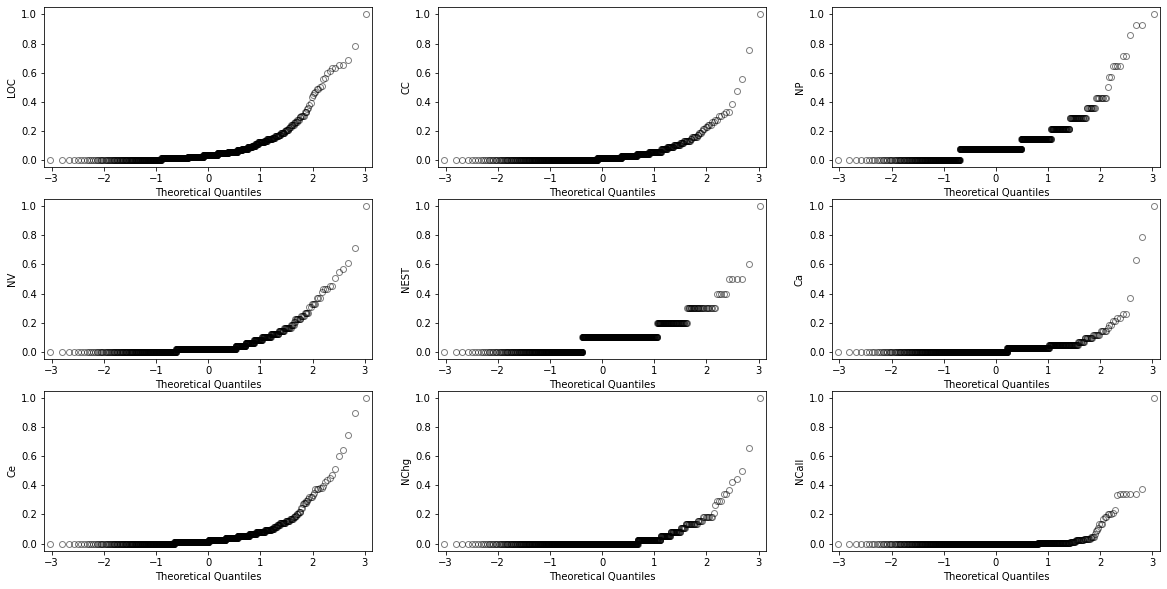

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
ax= axes.flatten()
for i in range(len(list_columns)):
    col_name = list_columns[i]
    sm.qqplot(scaled_data[col_name], marker='o', markerfacecolor='none', markeredgecolor='k', alpha=0.5,
              ax = ax[i])
    ax[i].set_ylabel(col_name)

# plt.tight_layout(pad=1.5)
plt.show()

## Correlation

<AxesSubplot:>

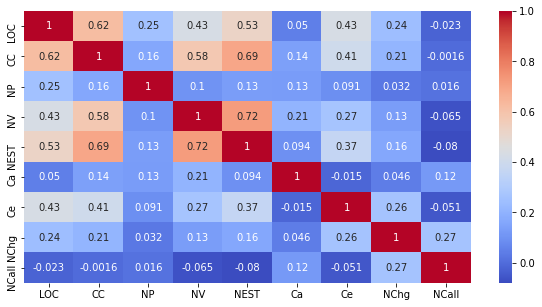

In [8]:
p_corr = scaled_data[list_columns].corr(method='kendall')
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(p_corr, xticklabels=p_corr.columns, yticklabels=p_corr.columns, annot=True, cmap='coolwarm', ax = ax)

## PCA

In [16]:
comp = len(list_columns)
pca_ = PCA(n_components=comp, random_state=42)
pca_.fit(scaled_data[list_columns])

importance = {}

# by looking at the PC1 (First Principal Component) we can conclude
# which features are the most important (they have higher values)
print('PC 1:', pca_.components_[0])
for i in range(len(pca_.components_[0])):
    val = round(pca_.components_[0][i], 6)
    print('var ', i, val)
    importance[val] = list_columns[i]
print('explained variance: ', pca_.explained_variance_ratio_)

dict_keys = list(importance.keys())
dict_keys.sort(reverse = True)
print('first 3 metrics:', importance[dict_keys[0]], importance[dict_keys[1]], importance[dict_keys[2]])

PC 1: [ 0.56564053  0.35112632  0.16927672  0.42620949  0.34958747  0.00073459
  0.40464763  0.24555048 -0.01432774]
var  0 0.565641
var  1 0.351126
var  2 0.169277
var  3 0.426209
var  4 0.349587
var  5 0.000735
var  6 0.404648
var  7 0.24555
var  8 -0.014328
explained variance:  [0.4630633  0.20996295 0.10158895 0.05701637 0.04783686 0.04169297
 0.03741397 0.02431819 0.01710645]
first 3 metrics: LOC NV Ce


## Elbow for k-means

In [10]:
from scipy.spatial.distance import cdist

kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42}
# A list holds the SSE values for each k
sse = []
distortions = []
X = scaled_data[list_columns]
for k in range(1, 11):
    ekmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    ekmeans.fit(X)
    sse.append(ekmeans.inertia_)
    distortions.append(sum(np.min(cdist(X, ekmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

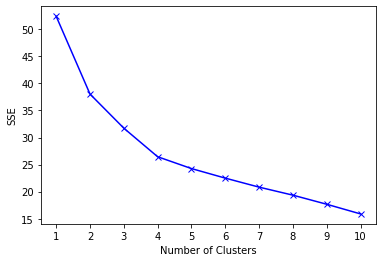

In [11]:
plt.plot(range(1, 11), sse, 'bx-')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [12]:
from kneed import KneeLocator
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print('for sse ', kl.elbow)
kl = KneeLocator(range(1, 11), distortions, curve="convex", direction="decreasing")
print('for distortions', kl.elbow)

for sse  4
for distortions 5


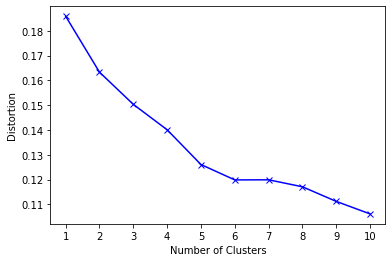

In [13]:
plt.plot(range(1, 11), distortions, 'bx-')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Distortion")
plt.show()

## BIC for EM

winner:  ('diag', 10)


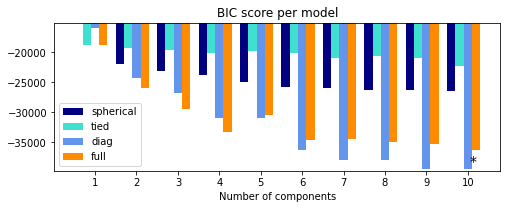

In [18]:


import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

# Number of samples per component
n_samples = scaled_data.shape[0]
X = scaled_data[list_columns].to_numpy()

lowest_bic = np.infty
bic = []
n_components_range = range(1, 11)
cv_types = ['spherical', 'tied', 'diag', 'full']
win='',0
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type,
                                      random_state=42)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            win = cv_type, n_components

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])
clf = best_gmm
bars = []

print("winner: ", win)

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

plt.show()